In [ ]:
!pip install basicsr
!pip install realesrgan

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.5/172.5 kB 5.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.4/45.4 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 104.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.7/254.7 kB 24.8 MB/s eta 0:00:00
  Created wheel for basicsr: filename=basicsr-1.4.2-py3-none-any.whl size=214818 sha256=c0af89e5db787b9c57bfc60dc1486b92aae6bfe3dd7b45a886ca4a6f2744feb9
  Stored in directory: /root/.cache/pip/wheels/38/83/99/2d8437cc652a01af27df5ff037a4075e95b52d67705c5f30ca
Successfully built basicsr
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.0/178.0 kB 8.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.6/59.6 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.2/52.2 kB 5.3 MB/s eta

Files already downloaded and verified


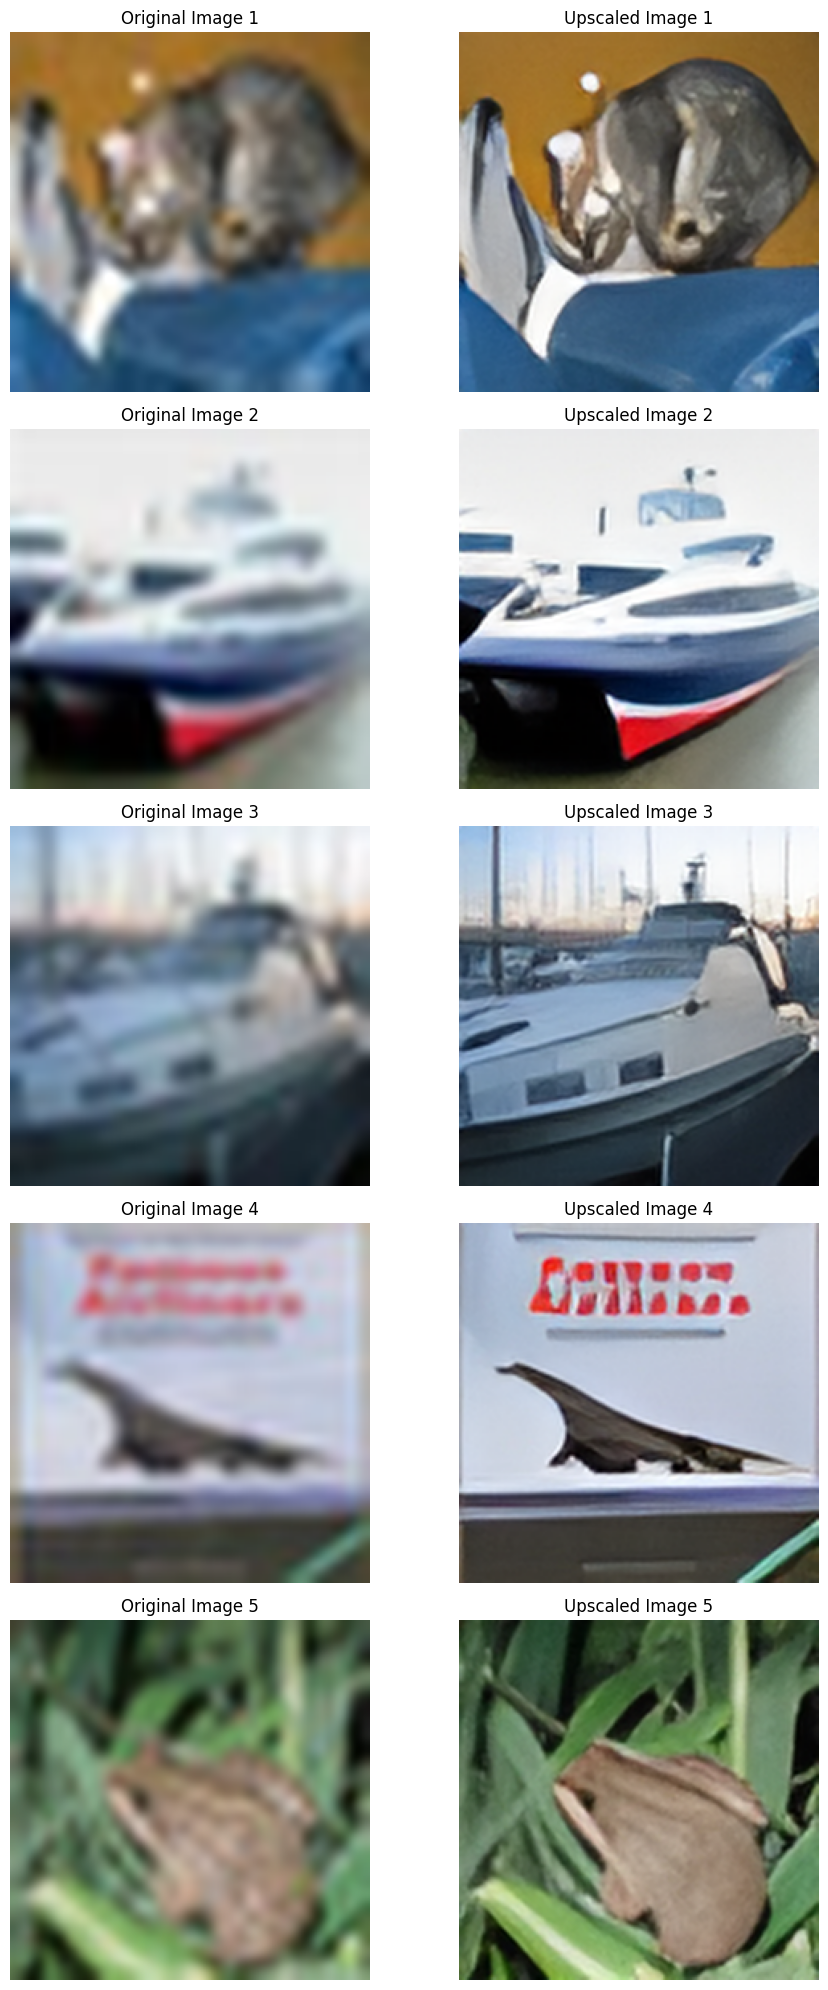

In [ ]:
import torch
from torchvision import datasets, transforms
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt
from basicsr.archs.rrdbnet_arch import RRDBNet
from realesrgan import RealESRGANer

# Step 1: Load CIFAR-10 Dataset
transform = transforms.ToTensor()
cifar10 = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Define Real-ESRGAN Upscaler
model_path = './RealESRGAN_x4plus.pth'  # Path to your pre-trained 8x model
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Initialize RRDBNet model
model = RRDBNet(num_in_ch=3, num_out_ch=3, num_feat=64, num_block=23, num_grow_ch=32, scale=8)
upscaler = RealESRGANer(scale=8, model_path=model_path, model=model, tile=0, tile_pad=10, pre_pad=0, half=True, device=device)

# Step 2: Select and Process Test Images
fig, axes = plt.subplots(5, 2, figsize=(10, 20))  # Set up a 5x2 grid for plotting

for i in range(5):  # Process 5 images
    image_tensor, _ = cifar10[i]
    image = transforms.ToPILImage()(image_tensor)

    # Convert PIL image to OpenCV format (BGR)
    input_img = np.array(image)
    input_img_bgr = input_img[:, :, ::-1]  # Convert RGB to BGR for OpenCV

    # Step 3: Upscale the Image
    with torch.no_grad():
        output_img_bgr, _ = upscaler.enhance(input_img_bgr, outscale=8)

    # Resize output to 224x224 and convert to RGB
    output_img_bgr = cv2.resize(output_img_bgr, (224, 224), interpolation=cv2.INTER_LANCZOS4)
    output_img_rgb = output_img_bgr[:, :, ::-1]  # Convert BGR back to RGB

    # Convert images to displayable PIL format
    original_image_pil = image.resize((224, 224), Image.LANCZOS)  # Resize original to 224x224 for comparison
    output_image_pil = Image.fromarray(output_img_rgb)

    # Plot original and upscaled images side by side
    axes[i, 0].imshow(original_image_pil)
    axes[i, 0].set_title(f'Original Image {i + 1}')
    axes[i, 0].axis('off')

    axes[i, 1].imshow(output_image_pil)
    axes[i, 1].set_title(f'Upscaled Image {i + 1}')
    axes[i, 1].axis('off')

# Show the plot
plt.tight_layout()
plt.show()
